In [5]:
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from network import ScoreNet
from kfp import diffusion_coeff

sigma = 25
eps = 1e-6

model_score = ScoreNet()
ckpt = torch.load('../ckpt.pth', map_location=torch.device('cpu'))
model_score.load_state_dict(ckpt)
model_score.eval();

H = 28
W = 28
N = 10

In [6]:

## The error tolerance for the black-box ODE solver
def ode_sampler(score_model,
                diffusion_coeff,
                batch_size=64,
                z=None,
                eps=eps):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, H, W) * torch.sqrt(2 * diffusion_coeff(torch.ones(batch_size, 1, H, W), sigma)**2)
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, dtype=torch.float32).reshape(shape)

    time_steps = torch.tensor(time_steps, dtype=torch.float32).reshape((sample.shape[0],))
    with torch.no_grad():
      score_ = score_model(sample, time_steps)
    return score_.cpu().numpy().reshape((-1))

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    # time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t), sigma)
    return  -0.5 * (g**2) * score_eval_wrapper(x, t)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1))
  print(f"Number of function evaluations: {res.nfev}")
  sol = res.y #[:, -1].reshape(shape)
  return sol

In [7]:
sample_batch_size = 1
sampler = ode_sampler

#init_x = np.load("../init.npy")[-1].reshape((sample_batch_size, 1, H, W))
init_x = torch.rand(sample_batch_size, 1, H, W)

## Generate samples using the specified sampler.
samples = sampler(model_score,
                  diffusion_coeff,
                  sample_batch_size)

# for i in range(N):
#   plt.imshow(samples[:, i].reshape(H, W), cmap = 'gray')
#   plt.show()

Number of function evaluations: 254


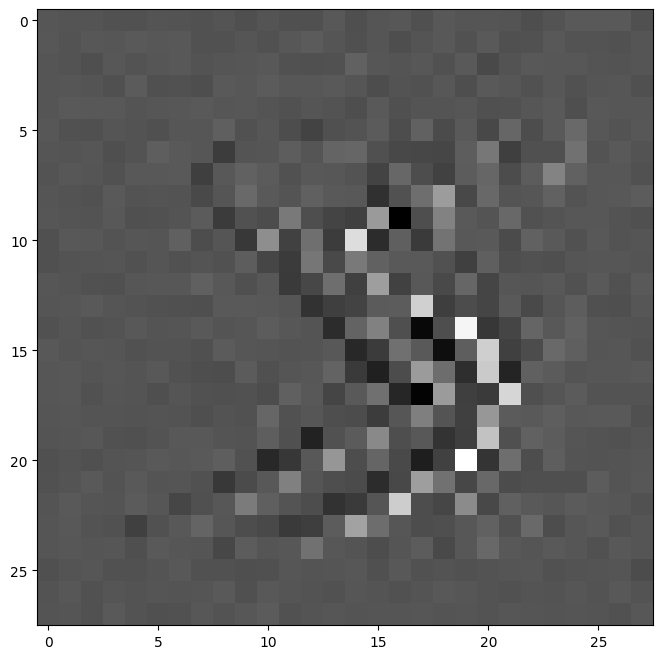

In [9]:
fig = plt.figure(figsize=(8,8));

im = plt.imshow(samples[:, -1].reshape(H, W), cmap="gray");
#ax.imshow(samples[:, 0].reshape(H, W), cmap="gray");

def frame(i):
    im.set_data(samples[:, i].reshape(H, W));
    return [im]

animation_fig = animation.FuncAnimation(fig, frame, frames=samples.shape[1], interval=0.2, blit=True,repeat_delay=2);

animation_fig.save("animation.gif");